In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import tkinter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from statistics import mean
from statistics import stdev as std
import statsmodels.formula.api as sm
pd.set_option("display.max_columns", None)
import statsmodels.api as sm
import matplotlib
import warnings
import statistics

warnings.filterwarnings('ignore')
%matplotlib inline

postive_vals = {} ## dict for postive MSRE $
negative_vals = {}# dict for negative MRSE ##


postive_vals_r2 = {} #dict for psotive r^2#
negative_vals_r2 = {} #dict for negative r^2#

postive_vals_mr2={}#dict for postive r^2 mean of cross validation#
negative_vals_mr2={}#dict for negative r^2 mean of cross validation#

postive_vals_std = {}#dict for postive std of cross validation#
negative_vals_std = {}#dict for negative std of cross validation#

def adj_r2 (X,y,y_pred):
    r_squared=r2_score(y,y_pred)
    r=(1-r_squared)
    y = (len(y)-1)/((len(y)-X.shape[1]-1))
    adjusted_r_squared= 1-(y*r)
    return adjusted_r_squared


# Auto backward Elimination fucntion##
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(1, numVars):## start from one skip on the intercept ## 
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    print("Reomoved col ",(columns[j]))
                    columns = np.delete(columns, j)
                    
                    
    regressor_OLS.summary()
    return x, columns

def Season_maker_zaada(x):
    if x  in ["Jan","Feb","Dec"]:
        return "Winter"
    elif x  in ["Apr","May","Mar"]:
        return "Spring"
    elif x  in ["Jun","Jul","Aug"]:
        return "Summer"
    else:
        return 'Autumn'
    # Add elif statements
    
def merge_fix_cols(df_company,df_product,uniqueID):## merge 2 dataframes and remove the duplicate ## 

    df_merged = pd.merge(df_company,
                         df_product,
                         how='left',on=uniqueID)    
    for col in df_merged:
        if col.endswith('_x'):
            df_merged.rename(columns = lambda col:col.rstrip('_x'),inplace=True)
        elif col.endswith('_y'):
            to_drop = [col for col in df_merged if col.endswith('_y')]
            df_merged.drop(to_drop,axis=1,inplace=True)
        else:
            pass
    return df_merged

dataset = pd.read_csv("COVID-19_Daily_Testing_-_By_Test.csv") ## read the csv file ## 
dataset["unique_id_zaada"] = dataset.index + 1## insert insex for rows so later can be merged ##
first_column = dataset.pop('unique_id_zaada')
dataset.insert(0, 'unique_id_zaada', first_column)
## insert first colum of uniqe id ## 



df = dataset
df.fillna(value=df.mean(), inplace=True) ## fil nulls with the mean ## 
df = df.drop(df[df.Date.isnull()].index) ## drop null dates ## 
df['Month']=df['Date'].astype('datetime64[ns]').dt.strftime('%b') # make featuer of the monuth according to the date ##

dataset=df.sort_values(by="Date")

df['Season']=df['Month'].apply(Season_maker_zaada)

temp = df.pop('Day')
df.insert(5, 'Day', temp)## make day not in the begining ###
df

,unique_id_zaada,Date,Positive Tests,Not Positive Tests,Total Tests,Day,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Positive Tests - Age 0-17,Positive Tests - Age 18-29,Positive Tests - Age 30-39,Positive Tests - Age 40-49,Positive Tests - Age 50-59,Positive Tests - Age 60-69,Positive Tests - Age 70-79,Positive Tests - Age 80+,Positive Tests - Age Unknown,Positive Tests - Female,Positive Tests - Male,Positive Tests - Unknown Gender,Positive Tests - Latinx,Positive Tests - Asian Non-Latinx,Positive Tests - Black Non-Latinx,Positive Tests - White Non-Latinx,Positive Tests - Other Race Non-Latinx,Positive Tests - Unknown Race/Ethnicity,Not-Positive Tests - Age 0-17,Not-Positive Tests - Age 18-29,Not-Positive Tests - Age 30-39,Not-Positive Tests - Age 40-49,Not-Positive Tests - Age 50-59,Not-Positive Tests - Age 60-69,Not-Positive Tests - Age 70-79,Not-Positive Tests - Age 80+,Not-Positive Tests - Age Unknown,Not-Positive Tests - Female,Not-Positive Tests - Male,Not-Positive Tests - Gender Unknown,Not-Positive Tests - Latinx,Not-Positive Tests - Asian Non-Latinx,Not-Positive Tests - Black Non-Latinx,Not-Positive Tests - White Non-Latinx,Not-Positive Tests - Other Race Non-Latinx,Not-Positive Tests - Unknown Race/Ethnicity,Month,Season
0,1,09/17/2020,435,8194,8629,Thursday,544,2415,1939,1121,1021,848,423,316,2,4558,3721,350,1389,298,1540,1914,288,3200,45,136,93,55,47,35,17,7,0,216,218,1,193,13,57,130,8,34,499,2279,1846,1066,974,813,406,309,2,4342,3503,349,1196,285,1483,1784,280,3166,Sep,Autumn
1,2,07/30/2020,427,7893,8320,Thursday,645,2159,1759,1171,995,820,414,347,10,4553,3436,331,1759,265,1593,1867,302,2534,55,104,95,67,57,27,11,10,1,221,204,2,203,14,92,83,4,31,590,2055,1664,1104,938,793,403,337,9,4332,3232,329,1556,251,1501,1784,298,2503,Jul,Summer
2,3,08/08/2021,292,7010,7302,Sunday,817,1932,1594,1205,839,470,280,161,4,3986,3287,29,737,346,1034,1743,262,3180,47,78,66,35,26,13,18,8,1,165,126,1,56,9,76,90,21,40,770,1854,1528,1170,813,457,262,153,3,3821,3161,28,681,337,958,1653,241,3140,Aug,Summer
3,4,03/11/2020,8,56,64,Wednesday,5,14,14,11,9,7,2,1,1,41,18,5,9,4,13,14,3,21,0,2,0,2,3,1,0,0,0,2,6,0,0,0,4,4,0,0,5,12,14,9,6,6,2,1,1,39,12,5,9,4,9,10,3,21,Mar,Spring
4,5,03/20/2021,337,6067,6404,Saturday,634,1557,1399,931,749,610,332,188,4,3356,2913,135,1031,330,1250,1731,317,1745,38,105,74,44,35,26,7,8,0,177,160,0,95,17,92,95,17,21,596,1452,1325,887,714,584,325,180,4,3179,2753,135,936,313,1158,1636,300,1724,Mar,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,631,02/09/2021,461,15621,16082,Tuesday,794,4820,2921,2134,2055,1727,852,728,51,8409,7109,564,1693,931,2972,4053,565,5868,48,130,83,73,56,41,17,13,0,244,213,4,131,21,111,127,20,51,746,4690,2838,2061,1999,1686,835,715,51,8165,6896,560,1562,910,2861,3926,545,5817,Feb,Winter
631,632,08/06/2020,389,6497,6886,Thursday,546,2029,1615,916,781,555,271,164,9,3886,2914,86,1444,183,1431,1486,255,2087,41,124,83,63,34,22,12,10,0,205,184,0,173,7,93,78,18,20,505,1905,1532,853,747,533,259,154,9,3681,2730,86,1271,176,1338,1408,237,2067,Aug,Summer
632,633,11/17/2020,2788,21191,23979,Tuesday,1595,6799,5018,3336,3073,2333,1111,704,10,12972,10493,514,4328,911,3415,4920,782,9623,300,657,561,443,395,256,114,60,2,1426,1354,8,1208,86,439,609,111,335,1295,6142,4457,2893,2678,2077,997,644,8,11546,9139,506,3120,825,2976,4311,671,9288,Nov,Autumn
633,634,02/16/2021,254,9323,9577,Tuesday,423,2333,1803,1216,1241,1117,712,728,4,5020,4288,269,996,427,1508,2455,458,3733,25,81,35,47,28,20,9,9,0,1

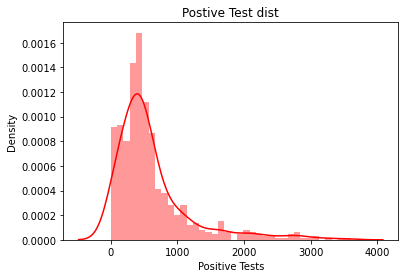

In [72]:
sns.distplot(dataset["Positive Tests"],color='red').set_title("Postive Test dist")## dist of the postive tests###
plt.show()

Text(0.5, 1.0, 'Negative Test dist')

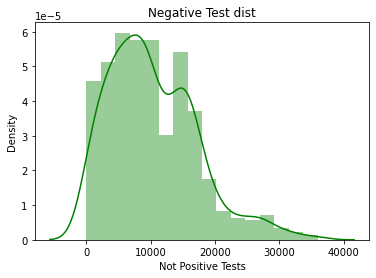

In [73]:
sns.distplot(dataset["Not Positive Tests"],color='green').set_title("Negative Test dist")## dist of the postive tests###

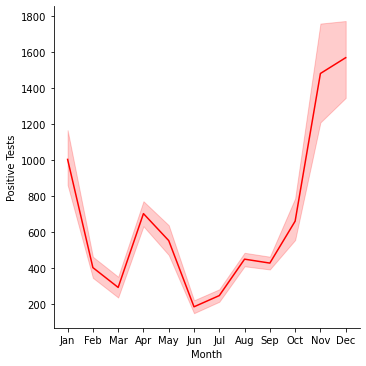

In [78]:
sns.relplot(x="Month", y="Positive Tests", data=dataset,kind="line",color='red')

plt.show()

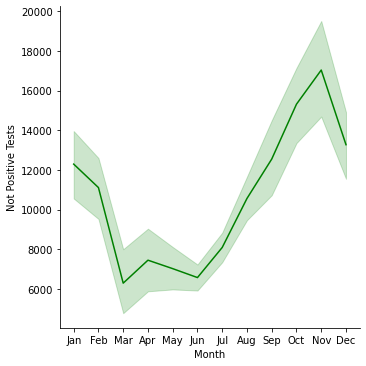

In [79]:
sns.relplot(x="Month", y="Not Positive Tests",dashes=False, markers=True, kind="line", data=dataset,color='g')
plt.show()

In [5]:
##postive ## 
dfp = df[["Positive Tests","Tests - Age 0-17","Tests - Age 18-29","Tests - Age 30-39","Tests - Age 40-49","Tests - Age 50-59",
"Tests - Age 60-69","Tests - Age 70-79","Tests - Age 80+","Tests - Age Unknown","Tests - Female","Tests - Male",
"Tests - Gender Unknown","Tests - Latinx","Tests - Asian Non-Latinx","Tests - Black Non-Latinx",
"Tests - White Non-Latinx","Tests - Other Race Non-Latinx","Tests - Unknown Race/Ethnicity",
'Month','Day',"unique_id_zaada","Date","Season"]]

## for postive ##
enc =OneHotEncoder (sparse=False) ## make onehotencoder## 
onehot_Month= enc.fit_transform(dfp["Month"].values.reshape(-1,1))##reshape beacuse of eror#
Month=pd.DataFrame(onehot_Month, columns=enc.get_feature_names())## data frame of the onehotencoder##
Month["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Month.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Month.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
onehot_Day= enc.fit_transform(dfp["Day"].values.reshape(-1,1))##reshape beacuse of eror#
Day=pd.DataFrame(onehot_Day, columns=enc.get_feature_names())## data frame of the onehotencoder##
Day["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Day.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Day.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 

onehot_Ses= enc.fit_transform(dfp["Season"].values.reshape(-1,1))##reshape beacuse of eror#
Season=pd.DataFrame(onehot_Ses, columns=enc.get_feature_names())## data frame of the onehotencoder##
Season["unique_id_zaada"] = dfp.index + 1## make unique id so can merge the dataframes ##
first_column = Season.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Season.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day
Season

tempo=merge_fix_cols(Month,Day,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 
tempo2=merge_fix_cols(tempo,Season,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 

dfp=merge_fix_cols(dfp,tempo2,'unique_id_zaada')# merge the df of the encdoding and the data frame with the rest  ## 

dfp.columns = [col.replace('x0_', '') for col in dfp.columns] #remove the x from the names of the columns ##
dfp = dfp.drop(columns=["Month"])## drop the unencdoding feathers ## 
dfp = dfp.drop(columns=["Day"])
dfp = dfp.drop(columns=["Date"])
dfp = dfp.drop(columns=["unique_id_zaada"])## drop the uniqe id ## 
dfp = dfp.drop(columns=["Season"])## drop the uniqe id ## 
total_tests=df['Total Tests'].values
dfp

,Positive Tests,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,435,544,2415,1939,1121,1021,848,423,316,2,4558,3721,350,1389,298,1540,1914,288,3200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,427,645,2159,1759,1171,995,820,414,347,10,4553,3436,331,1759,265,1593,1867,302,2534,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,292,817,1932,1594,1205,839,470,280,161,4,3986,3287,29,737,346,1034,1743,262,3180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8,5,14,14,11,9,7,2,1,1,41,18,5,9,4,13,14,3,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,337,634,1557,1399,931,749,610,332,188,4,3356,2913,135,1031,330,1250,1731,317,1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,461,794,4820,2921,2134,2055,1727,852,728,51,8409,7109,564,1693,931,2972,4053,565,5868,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
630,389,546,2029,1615,916,781,555,271,164,9,3886,2914,86,1444,183,1431,1486,255,2087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
631,2788,1595,6799,5018,3336,3073,2333,1111,704,10,12972,10493,514,4328,911,3415,4920,782,9623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
632,254,423,2333,1803,1216,1241,1117,712,728,4,5020,4288,269,996,427,1508,2455,458,3733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [6]:
dfn = df[["Not Positive Tests","Tests - Age 0-17","Tests - Age 18-29","Tests - Age 30-39","Tests - Age 40-49","Tests - Age 50-59",
"Tests - Age 60-69","Tests - Age 70-79","Tests - Age 80+","Tests - Age Unknown","Tests - Female","Tests - Male",
"Tests - Gender Unknown","Tests - Latinx","Tests - Asian Non-Latinx","Tests - Black Non-Latinx",
"Tests - White Non-Latinx","Tests - Other Race Non-Latinx","Tests - Unknown Race/Ethnicity"
,'Month','Day',"unique_id_zaada","Date","Season"]]


## for Negative ##

# make mopunth encoding ## 
enc =OneHotEncoder (sparse=False) ## make onehotencoder## 
onehot_Month= enc.fit_transform(dfn["Month"].values.reshape(-1,1))##reshape beacuse of eror#
Month=pd.DataFrame(onehot_Month, columns=enc.get_feature_names())## data frame of the onehotencoder##
Month["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Month.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Month.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 

#make day encoding ##
onehot_Day= enc.fit_transform(dfn["Day"].values.reshape(-1,1))##reshape beacuse of eror#
Day=pd.DataFrame(onehot_Day, columns=enc.get_feature_names())## data frame of the onehotencoder##
Day["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Day.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Day.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day

## make season encoding ##
onehot_Ses= enc.fit_transform(dfn["Season"].values.reshape(-1,1))##reshape beacuse of eror#
Season=pd.DataFrame(onehot_Ses, columns=enc.get_feature_names())## data frame of the onehotencoder##
Season["unique_id_zaada"] = dfn.index + 1## make unique id so can merge the dataframes ##
first_column = Season.pop("unique_id_zaada")#make uniqe id in the dataframe ## 
Season.insert(0, 'unique_id_zaada', first_column) ## make the uniqe id first col ## 
Month
Day
Season

tempo=merge_fix_cols(Month,Day,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 
tempo2=merge_fix_cols(tempo,Season,'unique_id_zaada')# merge the df of the encdoding   data frame   ## 

dfn=merge_fix_cols(dfn,tempo2,'unique_id_zaada')# merge the df of the encdoding and the data frame with the rest  ## 

dfn.columns = [col.replace('x0_', '') for col in dfn.columns] #remove the x from the names of the columns ##
dfn = dfn.drop(columns=["Month"])## drop the unencdoding feathers ## 
dfn = dfn.drop(columns=["Day"])
dfn = dfn.drop(columns=["Date"])
dfn = dfn.drop(columns=["unique_id_zaada"])## drop the uniqe id ## 
dfn = dfn.drop(columns=["Season"])## drop the uniqe id ## 
total_tests=df['Total Tests'].values
dfn

,Not Positive Tests,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 30-39,Tests - Age 40-49,Tests - Age 50-59,Tests - Age 60-69,Tests - Age 70-79,Tests - Age 80+,Tests - Age Unknown,Tests - Female,Tests - Male,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Black Non-Latinx,Tests - White Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,8194,544,2415,1939,1121,1021,848,423,316,2,4558,3721,350,1389,298,1540,1914,288,3200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7893,645,2159,1759,1171,995,820,414,347,10,4553,3436,331,1759,265,1593,1867,302,2534,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7010,817,1932,1594,1205,839,470,280,161,4,3986,3287,29,737,346,1034,1743,262,3180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,56,5,14,14,11,9,7,2,1,1,41,18,5,9,4,13,14,3,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,6067,634,1557,1399,931,749,610,332,188,4,3356,2913,135,1031,330,1250,1731,317,1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,15621,794,4820,2921,2134,2055,1727,852,728,51,8409,7109,564,1693,931,2972,4053,565,5868,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
630,6497,546,2029,1615,916,781,555,271,164,9,3886,2914,86,1444,183,1431,1486,255,2087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
631,21191,1595,6799,5018,3336,3073,2333,1111,704,10,12972,10493,514,4328,911,3415,4920,782,9623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
632,9323,423,2333,1803,1216,1241,1117,712,728,4,5020,4288,269,996,427,1508,2455,458,3733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


<AxesSubplot:>

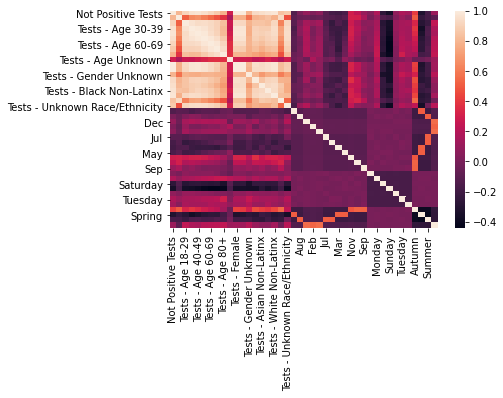

In [7]:
dfn_corr = dfn.corr()## show the corr matrix ##
sns.heatmap(dfn_corr)

<AxesSubplot:>

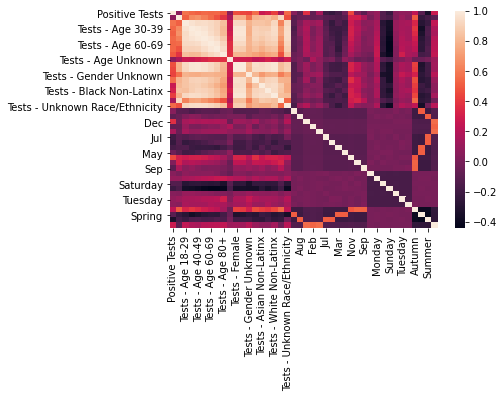

In [8]:
dfp_corr = dfp.corr()## show the corr matrix ##
sns.heatmap(dfp_corr)

In [9]:
y_positive = dfp.iloc[:,0:1].values ## take the y postive
y_negative = dfn.iloc[:, 0:1].values ## take the y negative
dfn = dfn.drop(columns=["Not Positive Tests"])## drop the y ## 
dfp = dfp.drop(columns=["Positive Tests"])## drop the y ## 


In [10]:
# Create correlation matrix
corr_matrix = dfp.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
dfp=dfp.drop(dfp[to_drop], axis=1)
print(to_drop)
dfp

['Tests - Age 30-39', 'Tests - Age 40-49', 'Tests - Age 50-59', 'Tests - Age 60-69', 'Tests - Age 70-79', 'Tests - Female', 'Tests - Male', 'Tests - Black Non-Latinx', 'Tests - White Non-Latinx']


,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 80+,Tests - Age Unknown,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,544,2415,316,2,350,1389,298,288,3200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,645,2159,347,10,331,1759,265,302,2534,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,817,1932,161,4,29,737,346,262,3180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,14,1,1,5,9,4,3,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,634,1557,188,4,135,1031,330,317,1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,794,4820,728,51,564,1693,931,565,5868,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
630,546,2029,164,9,86,1444,183,255,2087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
631,1595,6799,704,10,514,4328,911,782,9623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
632,423,2333,728,4,269,996,427,458,3733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [11]:

# Create correlation matrix
corr_matrix = dfn.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
dfn=dfn.drop(dfn[to_drop], axis=1)

dfn

,Tests - Age 0-17,Tests - Age 18-29,Tests - Age 80+,Tests - Age Unknown,Tests - Gender Unknown,Tests - Latinx,Tests - Asian Non-Latinx,Tests - Other Race Non-Latinx,Tests - Unknown Race/Ethnicity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Autumn,Spring,Summer,Winter
0,544,2415,316,2,350,1389,298,288,3200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,645,2159,347,10,331,1759,265,302,2534,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,817,1932,161,4,29,737,346,262,3180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,14,1,1,5,9,4,3,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,634,1557,188,4,135,1031,330,317,1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,794,4820,728,51,564,1693,931,565,5868,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
630,546,2029,164,9,86,1444,183,255,2087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
631,1595,6799,704,10,514,4328,911,782,9623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
632,423,2333,728,4,269,996,427,458,3733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:

# ##for the Positive regressions  ##
# X_train_p, X_test_p, y_train_p, y_test_p =train_test_split(StandardScaler().fit_transform(x_reg), y_positive, test_size = 0.333333,random_state = 0)
# ##for the negative regressions##
# X_train_n, X_test_n, y_train_n, y_test_n =train_test_split(StandardScaler().fit_transform(x_reg), y_negative, test_size = 0.333333,random_state = 0)

## took from https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf with a littel modification## 
## postive ## 


In [13]:
## took from https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf with a littel modification## 
## postive ## 
x_positive = dfp.values ## take the x's as the featuers list ##
x_positive_reg=np.append(arr=np.ones((len(x_positive),1)).astype(int),values=x_positive ,axis=1)## add a colum of 1 to the array for the x0 #


selected_columns_p = dfp.columns.values

selected_columns_p
SL = 0.05
x_positive_reg, selected_columns_p = backwardElimination(x_positive_reg, y_positive, SL, selected_columns_p)
X_train_p, X_test_p, y_train_p, y_test_p =train_test_split(StandardScaler().fit_transform(x_positive_reg), y_positive, test_size = 0.33333,random_state = 0,shuffle=True)

sc = StandardScaler()
X_train_p = sc.fit_transform(X_train_p)
X_test_p = sc.transform (X_test_p)

Reomoved col  Autumn
Reomoved col  Tests - Latinx
Reomoved col  Monday
Reomoved col  Jul
Reomoved col  Wednesday
Reomoved col  Tuesday
Reomoved col  Tests - Age 0-17
Reomoved col  Sunday
Reomoved col  Dec
Reomoved col  Mar
Reomoved col  Saturday
Reomoved col  May
Reomoved col  Summer
Reomoved col  Nov
Reomoved col  Tests - Gender Unknown
Reomoved col  Jun


In [14]:
selected_columns_p

array(['Tests - Age 18-29', 'Tests - Age 80+', 'Tests - Age Unknown',
       'Tests - Asian Non-Latinx', 'Tests - Other Race Non-Latinx',
       'Tests - Unknown Race/Ethnicity', 'Apr', 'Aug', 'Feb', 'Jan',
       'Oct', 'Sep', 'Friday', 'Thursday', 'Spring', 'Winter'],
      dtype=object)

In [15]:
## Negative ## 
x_negative = dfn.values ## last col
x_negative_reg=np.append(arr=np.ones((len(x_negative),1)).astype(int),values=x_negative ,axis=1)## add a colum of 1 to the array for the x0 #

selected_columns_n = dfn.columns
selected_columns_n

SL = 0.05
x_negative_reg, selected_columns_n = backwardElimination(x_negative_reg, y_negative, SL, selected_columns_n)

## negative train test and validate ## 
X_train_n, X_test_n, y_train_n, y_test_n =train_test_split(x_negative_reg, y_negative, test_size = 0.33333,random_state = 0,shuffle=True)

sc = StandardScaler()
X_train_n = sc.fit_transform(X_train_n)
X_test_n = sc.transform (X_test_n)


Reomoved col  Jul
Reomoved col  Dec
Reomoved col  Summer


In [16]:
selected_columns_n

Index(['Tests - Age 0-17', 'Tests - Age 18-29', 'Tests - Age 80+',
       'Tests - Age Unknown', 'Tests - Gender Unknown', 'Tests - Latinx',
       'Tests - Asian Non-Latinx', 'Tests - Other Race Non-Latinx',
       'Tests - Unknown Race/Ethnicity', 'Apr', 'Aug', 'Feb', 'Jan', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Autumn', 'Spring',
       'Winter'],
      dtype='object')

linear regression Positive
_______________________________________
Root_mean_squared_error is 198.2354119102928
r^2 socre is  0.9025102689044543
avg of cross validation score is  0.8340998225696652
std cross validation score is  0.06822034840006462


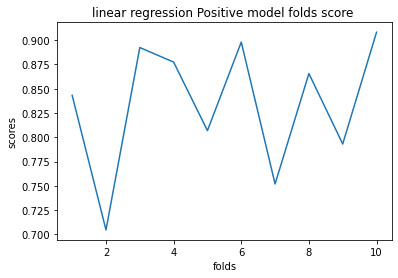

In [17]:
##multiply linear regression for the postive ##
print("linear regression Positive")
print("_______________________________________")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

regressor_p = LinearRegression() ## make regression # 
regressor_p.fit(X_train_p, y_train_p)# train the model #

y_pred = regressor_p.predict(X_test_p)## the predication of postive ## 
error = y_test_p-y_pred




RMSE=sqrt(mean_squared_error(y_test_p,y_pred))## calc the RMSE #
score=adj_r2(X_test_p,y_test_p,y_pred)# calc the adj r^2 beacuse of multi featuers ##
print("Root_mean_squared_error is",RMSE)
print("r^2 socre is ",score)

#inert into the dicts ## 
postive_vals["linear  regression "]=RMSE
postive_vals_r2["linear  regression "]=score



## make cross validation and take the score for the dicts ##
scores=cross_val_score(estimator=regressor_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2',) #you can also try scoring=‘r2’
folds=range(1,11)
## make a fig that show each fold r^2 score 
plt.plot(folds,scores)
plt.title('linear regression Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
postive_vals_std["linear  regression "]=std(scores) 
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores)) 
postive_vals_mr2["linear  regression "]=mean(scores) 
plt.show()



linear regression Negative
_______________________________________
Root mean_squared_error is 403.5461965840346
r^2 socre is  0.9956647923250375
avg of cross validation score is  0.9945022135529596
std cross validation score is  0.0025851811790910443


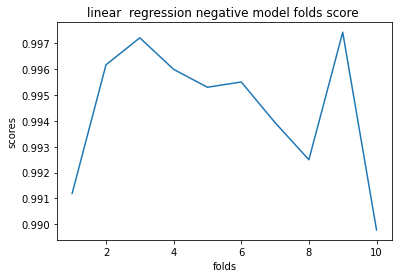

In [18]:
##multiply linear regression for negative ##
print("linear regression Negative")
print("_______________________________________")
## same just for the negative ##

regressor_n = LinearRegression()
regressor_n.fit(X_train_n, y_train_n)

y_pred = regressor_n.predict(X_test_n)## the predication of postive ## 
error = y_test_n-y_pred## the postive eror##
error




RMSE=sqrt(mean_squared_error(y_test_n,y_pred))
score=adj_r2(X_test_n,y_test_n,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is ",score)

negative_vals["linear  regression "]=RMSE
negative_vals_r2["linear  regression "]=score

scores=cross_val_score(estimator=regressor_n,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
folds=range(1,11)
plt.plot(folds,scores)
plt.title('linear  regression negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["linear  regression "]=std(scores)
negative_vals_mr2["linear  regression "]=mean(scores) 

plt.show()

Positives_validation


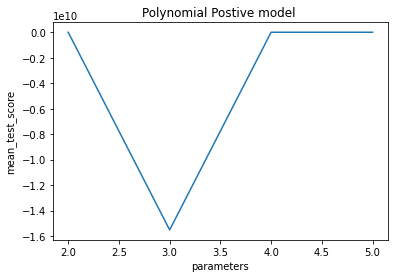

-----!!!!!!!
The Best Dgree is :2


In [19]:
## Polynomial regression

rs=[]

print("Positives_validation")

best=0 ## best degree #
d2=0# temp#
r2g=dict()

#check what is the best dgree for poly reg ## 
for i in range(2,6) :
    poly_reg_p = PolynomialFeatures(degree = i)## poly reg with dgree of i ##
    x_poly_train = poly_reg_p.fit_transform(X_train_p) ## poly the test data set ## 

    lin_reg_p = LinearRegression() 
    linp=lin_reg_p.fit(x_poly_train, y_train_p) ## train the data ##

    ##Evaluation for  dgree##
    y_poly_pred=lin_reg_p.predict(poly_reg_p.fit_transform(X_test_p))

    RMSE = sqrt(mean_squared_error(y_test_p,y_poly_pred))
    r2 =adj_r2(X_test_p,y_test_p,y_poly_pred)
    
    if r2>d2 :## pick the best r^2 ##
        best=i
        d2=r2
    # report performance
    rs.append(r2)

plt.plot(range(2,6),rs)
plt.title('Polynomial Postive model ')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()
print("-----!!!!!!!")
print("The Best Dgree is :"+str(best))

polynumial Positive test
_______________________________________
Root mean_squared_error is 169.1431144341045
adj r^2 socre is  0.9290250584777919


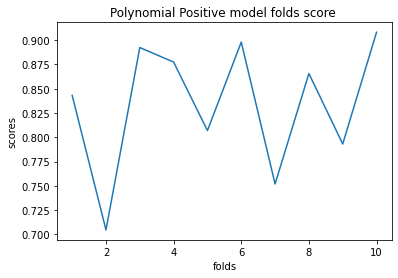

avg of cross validation score is  0.8340998225696652
std cross validation score is  0.06822034840006462


In [20]:
#polynumial regression using 1dgree as the dgree beacuse lowest std in cross validation & have the highest r^2 ## 
##test !!!!!!!##

##postives##
print("polynumial Positive test")
print("_______________________________________")
poly_reg = PolynomialFeatures(best)## make polyni,ail##
xp = poly_reg.fit_transform(X_train_p)## make x polynomial##

poly_regressor_p = LinearRegression()
poly_regressor_p.fit(xp, y_train_p)

xt = poly_reg.fit_transform(X_test_p)## make x polynomial##
y_pred = poly_regressor_p.predict(xt)## the predication of postive ## 
error = y_test_p-y_pred## the postive eror##
error

RMSE=sqrt(mean_squared_error(y_test_p,y_pred))
score=adj_r2(X_test_p,y_test_p,y_pred)

print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is ",score)

postive_vals["polynumial regression"]=RMSE
postive_vals_r2["polynumial regression"]=score

scores=cross_val_score(estimator=poly_regressor_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
folds=range(1,11)

plt.plot(folds,scores)
plt.title('Polynomial Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()

print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["polynumial regression"]=std(scores)
postive_vals_mr2["polynumial regression"]=mean(scores)

Polynomial Negatives validation
-----!!!!!!!
The Best Dgree is :2


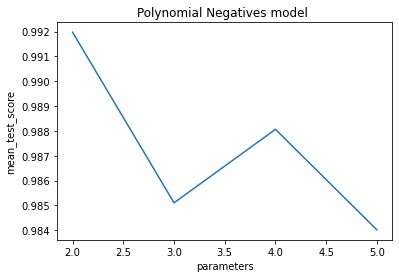

In [21]:

print("Polynomial Negatives validation")
best=0
d2=0
rs=[]
for i in range(2,6):
    poly_reg = PolynomialFeatures(degree = i)## make polyni,ail##
    xn = poly_reg.fit_transform(X_train_n)## make x polynomial##

    lin_reg_2 = LinearRegression()
    lin2=lin_reg_2.fit(xn,y_train_n)

    #Evalation#
    y_noly_nred=lin_reg_2.predict(poly_reg.fit_transform(X_test_n))
    RMSE = sqrt(mean_squared_error(y_test_n,y_noly_nred))
    r2 =adj_r2(X_test_n,y_test_n,y_noly_nred)


    if r2>d2 :
        best=i
        d2=r2
    
    rs.append(r2)

print("-----!!!!!!!")
print("The Best Dgree is :"+str(best))
plt.plot(range(2,6),rs)
plt.title('Polynomial Negatives model ')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()


polynumial Negative test
_______________________
_________________
Root mean_squared_error is 549.2013823328194
adj r^2 socre is  0.9919705345570017
_________________


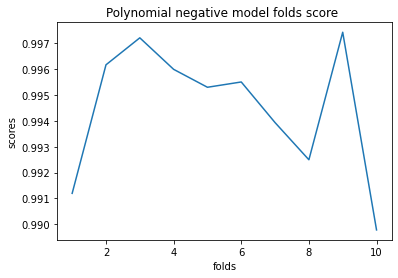

avg of cross validation score is  0.9945022135529596
std cross validation score is  0.0025851811790910443


In [22]:
#polynumial regression using 1dgree as the dgree beacuse lowest std in cross validation & have the highest r^2 ## 

#negative ## 

print("polynumial Negative test")
print("_______________________")
poly_reg = PolynomialFeatures(best)## make polyni,ail##
xp = poly_reg.fit_transform(X_train_n)## make x polynomial##

poly_regressor_n = LinearRegression()
poly_regressor_n.fit(xp, y_train_n)

xt = poly_reg.fit_transform(X_test_n)## make x polynomial##
y_pred = poly_regressor_n.predict(xt)## the predication of postive ## 
error = y_test_n-y_pred## the postive eror##
error


print("_________________")
RMSE=sqrt(mean_squared_error(y_test_n,y_pred))
score=adj_r2(X_test_n,y_test_n,y_pred)
print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is ",score)

negative_vals["polynumial regression"]=RMSE
negative_vals_r2["polynumial regression"]=score


scores=cross_val_score(estimator=poly_regressor_p,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Polynomial negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["polynumial regression"]=std(scores)
negative_vals_mr2["polynumial regression"]=mean(scores)

Ridge Positive stats
_______________________________
best alpha is  Ridge(alpha=0.19)
Root mean_squared_error is 198.29198095309124
adj r^2 socre is 0.9024546210503017
_________________


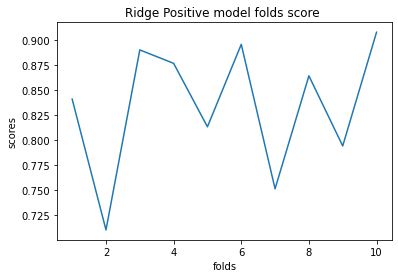

avg of cross validation score is  0.8347027152111772
std cross validation score is  0.06624824001718622


In [23]:
####Ridge##
#positive####
print("Ridge","Positive stats")
print("_______________________________")

from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold


parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)

Ridge_reg.fit(X_train_p,y_train_p)
# best estimator#
print("best alpha is ",Ridge_reg.best_estimator_)

Ridge_p = Ridge_reg.best_estimator_
Ridge_p.fit(X_train_p, y_train_p)             
pred2 = Ridge_p.predict(X_test_p) 

error = y_test_p-pred2## the postive eror##

RMSE=sqrt(mean_squared_error(y_test_p,pred2))
score=adj_r2(X_test_p,y_test_p,pred2)
print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is "+ str(score))


postive_vals["Ridge regression"]=RMSE
postive_vals_r2["Ridge regression"]=score

scores=cross_val_score(estimator=Ridge_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Ridge Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["Ridge regression"]=std(scores)
postive_vals_mr2["Ridge regression"]=mean(scores)

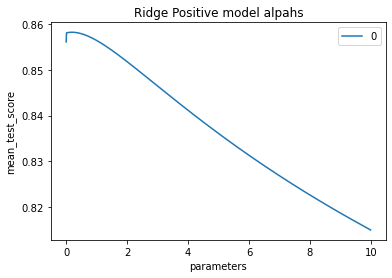

In [24]:
cvv=pd.DataFrame(Ridge_reg.cv_results_['mean_test_score'],Ridge_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title('Ridge Positive model alpahs')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()


Ridge Negative stats
_______________________________
best alpha is  Ridge(alpha=0.18)
Root mean_squared_error is 401.6154906509368
adj r^2 socre is 0.9957061753871091
_________________


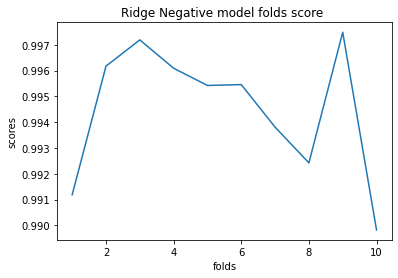

avg of cross validation score is  0.9945069269736391
std cross validation score is  0.002603580200153272


In [25]:
####Ridge##
#Negative####
print("Ridge","Negative stats")
print("_______________________________")
# took from https://machinelearningmastery.com/ridge-regression-with-python/#
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Ridge_reg.fit(X_train_n,y_train_n)

cvv=pd.DataFrame(Ridge_reg.cv_results_)
# best estimator
print("best alpha is ",Ridge_reg.best_estimator_)

Ridge_n = Ridge_reg.best_estimator_
Ridge_n.fit(X_train_n, y_train_n)             
pred3 = Ridge_n.predict(X_test_n)  
error = y_test_n-pred3## the postive eror##

RMSE=sqrt(mean_squared_error(y_test_n,pred3))
score=adj_r2(X_test_n,y_test_n,pred3)
print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is "+ str(score))

negative_vals["Ridge regression"]=RMSE
negative_vals_r2["Ridge regression"]=score

scores=cross_val_score(estimator=Ridge_n,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Ridge Negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
negative_vals_std["Ridge regression"]=std(scores)
negative_vals_mr2["Ridge regression"]=mean(scores)

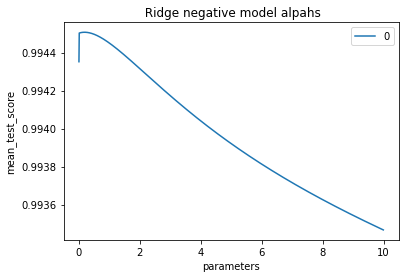

In [26]:
cvv=pd.DataFrame(Ridge_reg.cv_results_['mean_test_score'],Ridge_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Ridge negative model alpahs')
plt.xlabel('parameters')
plt.ylabel('mean_test_score')
plt.show()

Lasso Positive stats
_______________________________
best alpha is  Lasso(alpha=0.6900000000000001)
Root mean_squared_error is 198.7441475614733
adj r^2 socre is 0.9020092469970195
_________________


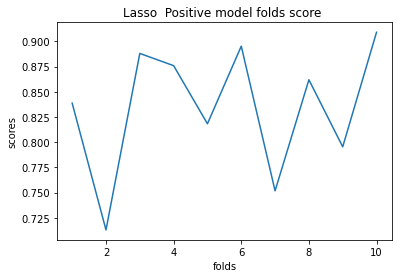

avg of cross validation score is  0.8347140495309517
std cross validation score is  0.0650059160772072


In [27]:
####Lasso##
#Positive####
print("Lasso","Positive stats")
print("_______________________________")


parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Lasso()

# define the grid search
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Lasso_reg.fit(X_train_p,y_train_p)

# best estimator
print("best alpha is ",Lasso_reg.best_estimator_)


lasso_p = Lasso_reg.best_estimator_# Fit the Lasso model
lasso_p.fit(X_train_p, y_train_p)# Create the model score
lasso_pred=lasso_p.predict(X_test_p)


RMSE=sqrt(mean_squared_error(y_test_p,lasso_pred))
score=adj_r2(X_test_p,y_test_p,lasso_pred)
print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is "+ str(score))


postive_vals["Lasso regression"]=RMSE
postive_vals_r2["Lasso regression"]=score


scores=cross_val_score(estimator=lasso_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Lasso  Positive model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))
postive_vals_std["Lasso regression"]=std(scores)
postive_vals_mr2["Lasso regression"]=mean(scores)

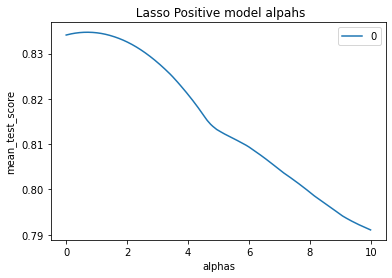

In [28]:
cvv=pd.DataFrame(Lasso_reg.cv_results_['mean_test_score'],Lasso_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Lasso Positive model alpahs')
plt.xlabel('alphas')
plt.ylabel('mean_test_score')
plt.show()
temp=pd.DataFrame(Ridge_reg.cv_results_)

Lasso Negative stats
_______________________________
best alpha is  Lasso(alpha=3.06)
Root mean_squared_error is 402.38945025683114
adj r^2 socre is 0.995689610045266
_________________


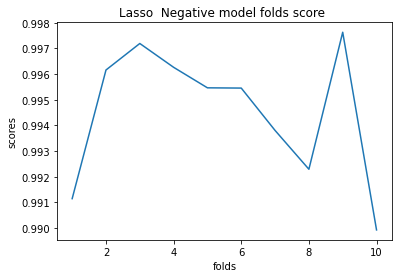

avg of cross validation score is  0.9945311157968768
std cross validation score is  0.002630764632907976


In [29]:
####Lasso##
#Negative####
print("Lasso","Negative stats")
print("_______________________________")

parameters = {'alpha':arange(0, 10, 0.01)}

# define the model/ estimator
model = Lasso()

# define the grid search
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=10)

Lasso_reg.fit(X_train_n,y_train_n)

# best estimator
print("best alpha is ",Lasso_reg.best_estimator_)


lasso_n = Lasso_reg.best_estimator_# Fit the Lasso model
lasso_n.fit(X_train_n, y_train_n)# Create the model score
lasso_nred=lasso_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,lasso_nred))
score=adj_r2(X_test_n,y_test_n,lasso_nred)
print("Root mean_squared_error is",RMSE)
print("adj r^2 socre is "+ str(score))

negative_vals["Lasso regression"]=RMSE
negative_vals_r2["Lasso regression"]=score


scores=cross_val_score(estimator=lasso_n,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Lasso  Negative model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

negative_vals_std["Lasso regression"]=std(scores)
negative_vals_mr2["Lasso regression"]=mean(scores)


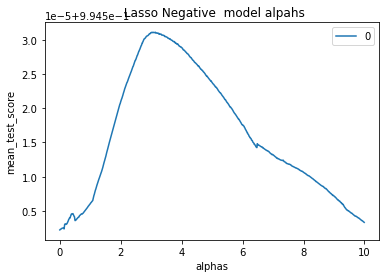

In [30]:
cvv=pd.DataFrame(Lasso_reg.cv_results_['mean_test_score'],Lasso_reg.cv_results_['param_alpha'])
cvv.plot()
plt.title(' Lasso Negative  model alpahs')
plt.xlabel('alphas')
plt.ylabel('mean_test_score')
plt.show()


Positive Knn
___________________________
best k {'metric': 'manhattan', 'n_neighbors': 9}
Root mean_squared_error is 216.17994557295208
r^2 socre is 0.8934026328100377
_________________


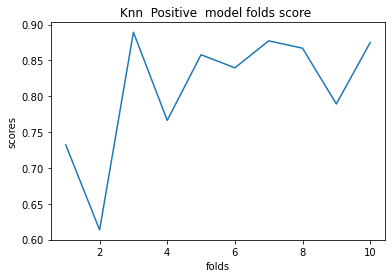

avg of cross validation score is  0.8107392339647244
std cross validation score is  0.0872191662257325


In [31]:
##Positive Knn###
x_negative = dfn.values
x_positive = dfp.values
#not regression so dont need featuer selecation ##
X_train_p, X_test_p, y_train_p, y_test_p =train_test_split(x_positive, y_positive, test_size = 0.33333,random_state = 0,shuffle=True)
## negative train test and validate ## 
X_train_n, X_test_n, y_train_n, y_test_n =train_test_split(x_negative, y_negative, test_size = 0.33333,random_state = 0,shuffle=True)

sc = StandardScaler()
X_train_p = sc.fit_transform(X_train_p)
X_test_p = sc.transform (X_test_p)

sc = StandardScaler()
X_train_n = sc.fit_transform(X_train_n)
X_test_n = sc.transform (X_test_n)

print("Positive Knn")
print("___________________________")




knn = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
n_neighbors = range(1, 70, 1)
metric = ['manhattan']
param_grid = dict(n_neighbors=n_neighbors,metric=metric)

  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='r2',)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_p, y_train_p)
print("best k",grid.best_params_)

knn_model_p=grid.best_estimator_
knn_model_p.fit(X_train_p, y_train_p)
y_pred_knn = knn_model_p.predict(X_test_p)

RMSE=sqrt(mean_squared_error(y_test_p,y_pred_knn))
score=r2_score(y_test_p,y_pred_knn)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Knn regression "]=RMSE
postive_vals_r2["Knn regression "]=score

scores=cross_val_score(estimator=knn_model_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Knn  Positive  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

postive_vals_std["Knn regression "]=std(scores)
postive_vals_mr2["Knn regression "]=mean(scores)


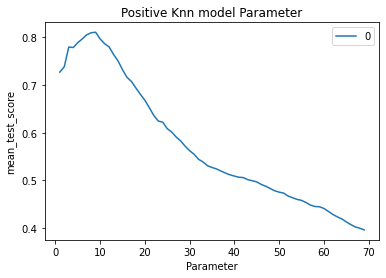

In [32]:
cvv=pd.DataFrame(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['param_n_neighbors'])
cvv.plot()
plt.title('Positive Knn model Parameter')
plt.xlabel('Parameter')
plt.ylabel('mean_test_score')
plt.show()


Negative Knn
___________________________
best k KNeighborsRegressor(metric='manhattan', n_neighbors=12)
Root mean_squared_error is 1485.7430235044126
r^2 socre is 0.9495911361810652
_________________


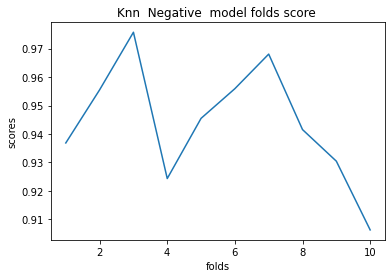

avg of cross validation score is  0.9440191815955788
std cross validation score is  0.020853448625639988


In [33]:
##Negative ###

print("Negative Knn")
print("___________________________")

knn = KNeighborsRegressor()

n_neighbors = range(1, 70, 1)
metric = ['manhattan']
param_grid = dict(n_neighbors=n_neighbors,metric=metric)

  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='r2')
  
# fitting the model for grid search
grid_search=grid.fit(X_train_n, y_train_n)
#print(grid.grid_scores_)
print("best k",grid.best_estimator_)

knn_model_n=grid.best_estimator_
knn_model_n.fit(X_train_n, y_train_n)
y_nred_knn = knn_model_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,y_nred_knn))
score=r2_score(y_test_n,y_nred_knn)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Knn regression "]=RMSE
negative_vals_r2["Knn regression "]=score


scores=cross_val_score(estimator=knn_model_n,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Knn  Negative  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
 
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

negative_vals_std["Knn regression "]=std(scores)
negative_vals_mr2["Knn regression "]=mean(scores)


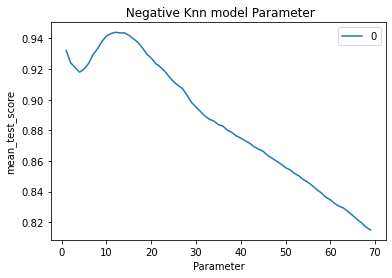

In [34]:
cvv=pd.DataFrame(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['param_n_neighbors'])
cvv.plot()
plt.title(' Negative Knn model Parameter')
plt.xlabel('Parameter')
plt.ylabel('mean_test_score')
plt.show()


Positive Random Forst 
_______________________________
Best parameters are  {'max_depth': 15, 'n_estimators': 134}
Root mean_squared_error is 245.28403283139386
r^2 socre is 0.8627683680317233
_________________


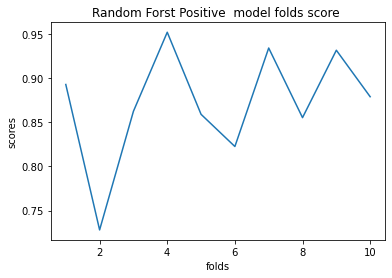

avg of cross validation score is  0.8715251557963812
std cross validation score is  0.06482967280756016


In [35]:
#Positive#
print("Positive Random Forst ")
print("_______________________________")

param_grid = {'max_depth':[1,5,10,15,20,None], 'n_estimators': range(1,150)}
rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid,scoring='r2', cv = 10,n_jobs=-1)
g_search.fit(X_train_p, y_train_p);
print("Best parameters are ",g_search.best_params_)

Random_f_p =g_search.best_estimator_
# fit the model on the whole dataset
Random_f_p.fit(X_train_p, y_train_p)

y_pred = Random_f_p.predict(X_test_p)

RMSE=sqrt(mean_squared_error(y_test_p,y_pred))
score=r2_score(y_test_p,y_pred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))


postive_vals["Random Forst regression "]=RMSE
postive_vals_r2["Random Forst regression "]=score


scores=cross_val_score(estimator=Random_f_p,X=X_train_p,y=y_train_p,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Random Forst Positive  model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))

postive_vals_std["Random Forst regression "]=std(scores)
postive_vals_mr2["Random Forst regression "]=mean(scores)

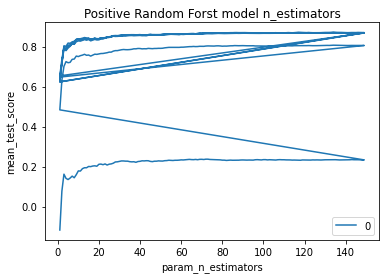

In [36]:
cvv=pd.DataFrame(g_search.cv_results_['mean_test_score'],g_search.cv_results_['param_n_estimators'])
cvv.plot()
plt.title('Positive Random Forst model n_estimators')
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
plt.show()


temp=pd.DataFrame(g_search.cv_results_)

Negative Random Forst 
_______________________________
Best parameters are  {'max_depth': 15, 'n_estimators': 15}
Root mean_squared_error is 790.5739537545032
r^2 socre is 0.9857273533672793
_________________


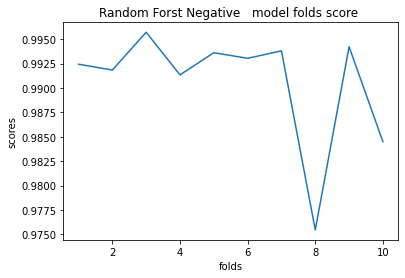

avg of cross validation score is  0.9905976929652339
std cross validation score is  0.006113811165938087


In [37]:
#Negative#
print("Negative Random Forst ")
print("_______________________________")
param_grid = {'max_depth':[1,5,10,15,20,None],'n_estimators':range(1,150)}
rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 10,n_jobs=-1)
g_search.fit(X_train_n, y_train_n);
print("Best parameters are ",g_search.best_params_)

Random_f_n =g_search.best_estimator_
# fit the model on the whole dataset
Random_f_n.fit(X_train_n, y_train_n)

y_nred = Random_f_n.predict(X_test_n)

RMSE=sqrt(mean_squared_error(y_test_n,y_nred))
score=r2_score(y_test_n,y_nred)
print("Root mean_squared_error is",RMSE)
print("r^2 socre is "+ str(score))

negative_vals["Random Forst regression "]=RMSE
negative_vals_r2["Random Forst regression "]=score



scores=cross_val_score(estimator=Random_f_n,X=X_train_n,y=y_train_n,cv=10,scoring='r2') #you can also try scoring=‘r2’
print("_________________")
plt.plot(folds,scores)
plt.title('Random Forst Negative   model folds score ')
plt.xlabel('folds')
plt.ylabel('scores')
plt.show()
print ("avg of cross validation score is ",mean(scores))
print ("std cross validation score is ",std(scores))\

negative_vals_std["Random Forst regression "]=std(scores)
negative_vals_mr2["Random Forst regression "]=mean(scores)

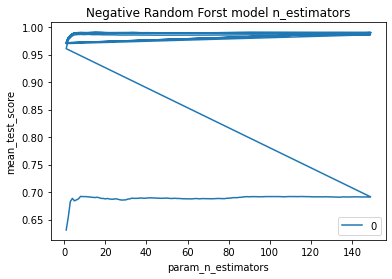

In [38]:
cvv=pd.DataFrame(g_search.cv_results_['mean_test_score'],g_search.cv_results_['param_n_estimators'])
cvv.plot()
plt.title('Negative Random Forst model n_estimators')
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
plt.show()


In [39]:
print(negative_vals)
print("__________________________________________________________")
print(postive_vals)
print("__________________________________________________________")
print(postive_vals_r2)
print("__________________________________________________________")
print(negative_vals_r2)

{'linear  regression ': 403.5461965840346, 'polynumial regression': 549.2013823328194, 'Ridge regression': 401.6154906509368, 'Lasso regression': 402.38945025683114, 'Knn regression ': 1485.7430235044126, 'Random Forst regression ': 790.5739537545032}
__________________________________________________________
{'linear  regression ': 198.2354119102928, 'polynumial regression': 169.1431144341045, 'Ridge regression': 198.29198095309124, 'Lasso regression': 198.7441475614733, 'Knn regression ': 216.17994557295208, 'Random Forst regression ': 245.28403283139386}
__________________________________________________________
{'linear  regression ': 0.9025102689044543, 'polynumial regression': 0.9290250584777919, 'Ridge regression': 0.9024546210503017, 'Lasso regression': 0.9020092469970195, 'Knn regression ': 0.8934026328100377, 'Random Forst regression ': 0.8627683680317233}
__________________________________________________________
{'linear  regression ': 0.9956647923250375, 'polynumial regres

In [40]:
max_key_negative_vals = min(negative_vals, key=negative_vals.get)
max_key_postive_vals = min(postive_vals, key=postive_vals.get)


max_key_negative_vals_r2 = max(negative_vals_r2, key=negative_vals_r2.get)
max_key_postive_vals_r2 = max(postive_vals_r2, key=postive_vals_r2.get)



print("Negative predication Best Model compared by Rmse is :",max_key_negative_vals)
print("Negative predication Best Model compared by r^2 is :",max_key_negative_vals_r2)

print("Positive predication Best Model compared by Rmse is :",max_key_postive_vals)
print("Positive predication Best Model compared by r^2 is :",max_key_postive_vals_r2)


Negative predication Best Model compared by Rmse is : Ridge regression
Negative predication Best Model compared by r^2 is : Ridge regression
Positive predication Best Model compared by Rmse is : polynumial regression
Positive predication Best Model compared by r^2 is : polynumial regression


In [41]:
postive_vals_mr2

{'linear  regression ': 0.8340998225696652,
 'polynumial regression': 0.8340998225696652,
 'Ridge regression': 0.8347027152111772,
 'Lasso regression': 0.8347140495309517,
 'Knn regression ': 0.8107392339647244,
 'Random Forst regression ': 0.8715251557963812}

In [42]:
df1 = pd.DataFrame(list(negative_vals_r2.items()), columns=['name', 'r2_score_n'])
df2 = pd.DataFrame(list(negative_vals.items()), columns=['name', 'RMSE_score_n'])
df5=pd.DataFrame(list(negative_vals_std.items()), columns=['name', 'std_score_n'])
df7=pd.DataFrame(list(negative_vals_mr2.items()), columns=['name', 'mean_kfold_r^2_n'])

df_n=merge_fix_cols(df1,df2,'name')
df_n=merge_fix_cols(df_n,df5,'name')
df_n=merge_fix_cols(df_n,df7,'name')

df3 = pd.DataFrame(list(postive_vals_r2.items()), columns=['name', 'r2_score_p'])
df4 = pd.DataFrame(list(postive_vals.items()), columns=['name', 'RMSE_score_p'])
df6=pd.DataFrame(list(postive_vals_std.items()), columns=['name', 'std_score_p'])
df8=pd.DataFrame(list(postive_vals_mr2.items()), columns=['name', 'mean_kfold_r^2_p'])

df_p=merge_fix_cols(df3,df4,'name')
df_p=merge_fix_cols(df_p,df6,'name')
df_p=merge_fix_cols(df_p,df8,'name')

df=merge_fix_cols(df_p,df_n,'name')

In [43]:
df=df.round(decimals=4)

In [44]:
df.style.highlight_max(color = 'lightgreen',subset=['r2_score_p','r2_score_n',"mean_kfold_r^2_n","mean_kfold_r^2_p"], axis = 0).highlight_min(color = 'lightgreen',subset=['RMSE_score_p',"RMSE_score_n","std_score_n","std_score_p"], axis = 0).highlight_min(color = 'lightcoral',subset=['r2_score_p','r2_score_n',"mean_kfold_r^2_n","mean_kfold_r^2_p"], axis = 0).highlight_max(color = 'lightcoral',subset=['RMSE_score_p',"RMSE_score_n","std_score_n","std_score_p"], axis = 0)



,name,r2_score_p,RMSE_score_p,std_score_p,mean_kfold_r^2_p,r2_score_n,RMSE_score_n,std_score_n,mean_kfold_r^2_n
0,linear regression,0.902500,198.235400,0.068200,0.834100,0.995700,403.546200,0.002600,0.994500
1,polynumial regression,0.929000,169.143100,0.068200,0.834100,0.992000,549.201400,0.002600,0.994500
2,Ridge regression,0.902500,198.292000,0.066200,0.834700,0.995700,401.615500,0.002600,0.994500
3,Lasso regression,0.902000,198.744100,0.065000,0.834700,0.995700,402.389500,0.002600,0.994500
4,Knn regression,0.893400,216.179900,0.087200,0.810700,0.949600,1485.743000,0.020900,0.944000
5,Random Forst regression,0.862800,245.284000,0.064800,0.871500,0.985700,790.574000,0.006100,0.990600


In [45]:
df.round(decimals=4)

,name,r2_score_p,RMSE_score_p,std_score_p,mean_kfold_r^2_p,r2_score_n,RMSE_score_n,std_score_n,mean_kfold_r^2_n
0,linear regression,0.9025,198.2354,0.0682,0.8341,0.9957,403.5462,0.0026,0.9945
1,polynumial regression,0.9290,169.1431,0.0682,0.8341,0.9920,549.2014,0.0026,0.9945
2,Ridge regression,0.9025,198.2920,0.0662,0.8347,0.9957,401.6155,0.0026,0.9945
3,Lasso regression,0.9020,198.7441,0.0650,0.8347,0.9957,402.3895,0.0026,0.9945
4,Knn regression,0.8934,216.1799,0.0872,0.8107,0.9496,1485.7430,0.0209,0.9440
5,Random Forst regression,0.8628,245.2840,0.0648,0.8715,0.9857,790.5740,0.0061,0.9906


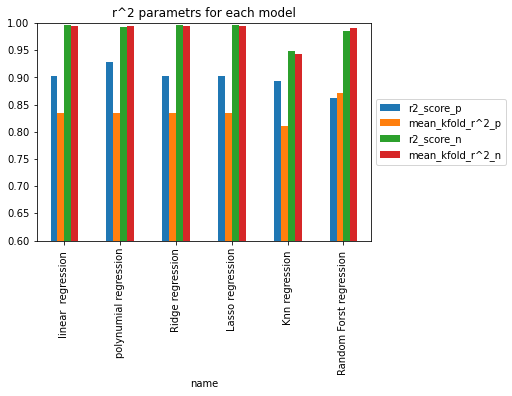

In [46]:
df.plot(x ='name', y=["r2_score_p","mean_kfold_r^2_p","r2_score_n","mean_kfold_r^2_n"], kind = 'bar')

plt.title('ww')## LABELS OF AXSIS ## 
plt.title('r^2 parametrs for each model')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={"size":10})## THE LEGEND ##
plt.ylim(0.6, 1,0.01)
plt.rcParams["figure.figsize"] = (8,4)
plt.show()

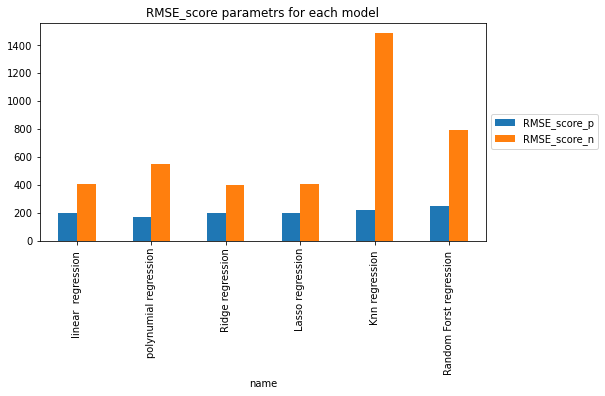

In [47]:
df.plot(x ='name', y=["RMSE_score_p","RMSE_score_n"], kind = 'bar')

plt.title('ww')## LABELS OF AXSIS ## 
plt.title('RMSE_score parametrs for each model')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={"size":10})## THE LEGEND ##

plt.rcParams["figure.figsize"] = (8,4)
plt.show()

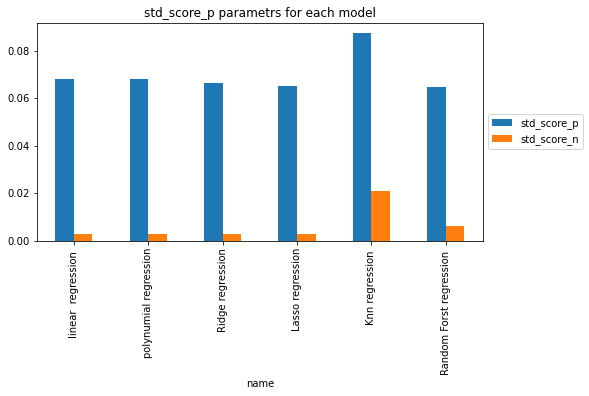

In [48]:
df.plot(x ='name', y=["std_score_p","std_score_n"], kind = 'bar')

plt.title('ww')## LABELS OF AXSIS ## 
plt.title('std_score_p parametrs for each model')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={"size":10})## THE LEGEND ##
#plt.ylim(0.6, 1,0.01)
plt.rcParams["figure.figsize"] = (8,4)
plt.show()